# Welcome to the world of whole slide images with LazySlide

<a target="_blank" href="https://colab.research.google.com/github/rendeirolab/lazyslide-workshop-scverse-conference-2025/blob/main/lazyslide_playground.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Run the following code if you're using a Colab environment. Remember to use a GPU instance for optimal performance.

In [1]:
# !pip install lazyslide scanpy transformers sacremoses environs cellpose python-igraph

## Download sample data

Let's download some sample data to explore. We'll use a whole slide image from the GTEx project - a tissue sample that we can analyze with LazySlide.

### Setup and imports

In [2]:
%config InlineBackend.figure_format = 'retina'

import warnings

warnings.filterwarnings("ignore")

Now let's import some packages:

In [3]:
from huggingface_hub import hf_hub_download

from wsidata import open_wsi
import lazyslide as zs

Download a sample whole slide image (WSI) from the GTEx tissue repository. This is stored in `.svs` format, a common format for digital pathology images.

In [4]:
slide = hf_hub_download(
    "rendeirolab/lazyslide-data",
    "GTEX-11DXX-1626.svs",
    repo_type="dataset",
)

## Create a wsidata object

`wsidata` is a specialized data structure built on top of SpatialData (from the scverse ecosystem) designed specifically for whole slide images. Just like AnnData provides a standardized way to work with single-cell data, wsidata provides a standardized interface for WSI analysis.

> wsidata = wsi reader + spatialdata

Open the downloaded WSI file and create a wsidata object:

In [5]:
wsi = open_wsi(slide)

Let's inspect the wsidata object. It shows a thumbnail of WSI, metadata and the spatialdata contents:

WSI: /Users/yzheng/.cache/huggingface/hub/datasets--rendeirolab--lazyslide-data/snapshots/9644d886889040fa10e757d912f249bbf936a979/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
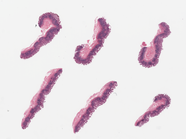

In [6]:
wsi

WSI files contain rich metadata in their properties. This includes information about the scanner, magnification, resolution, and more:

In [7]:
wsi.properties

SlideProperties(shape=[38717, 51791], n_level=3, level_shape=[[38717, 51791], [9679, 12947], [2419, 3236]], level_downsample=[1.0, 4.000167515184435, 16.005004736912298], mpp=0.4942, magnification=20.0, bounds=[0, 0, 51791, 38717])

An important note: wsidata is built as a subclass of SpatialData, making it fully compatible with the scverse ecosystem:

In [8]:
from spatialdata import SpatialData

print(f"The type of wsi is: {type(wsi)}")
print(f"wsidata is a subclass of spatialdata: {isinstance(wsi, SpatialData)}")

The type of wsi is: <class 'wsidata._model.core.WSIData'>
wsidata is a subclass of spatialdata: True


## Visualizing our whole slide image

Now that we've loaded our WSI, let's visualize it! 

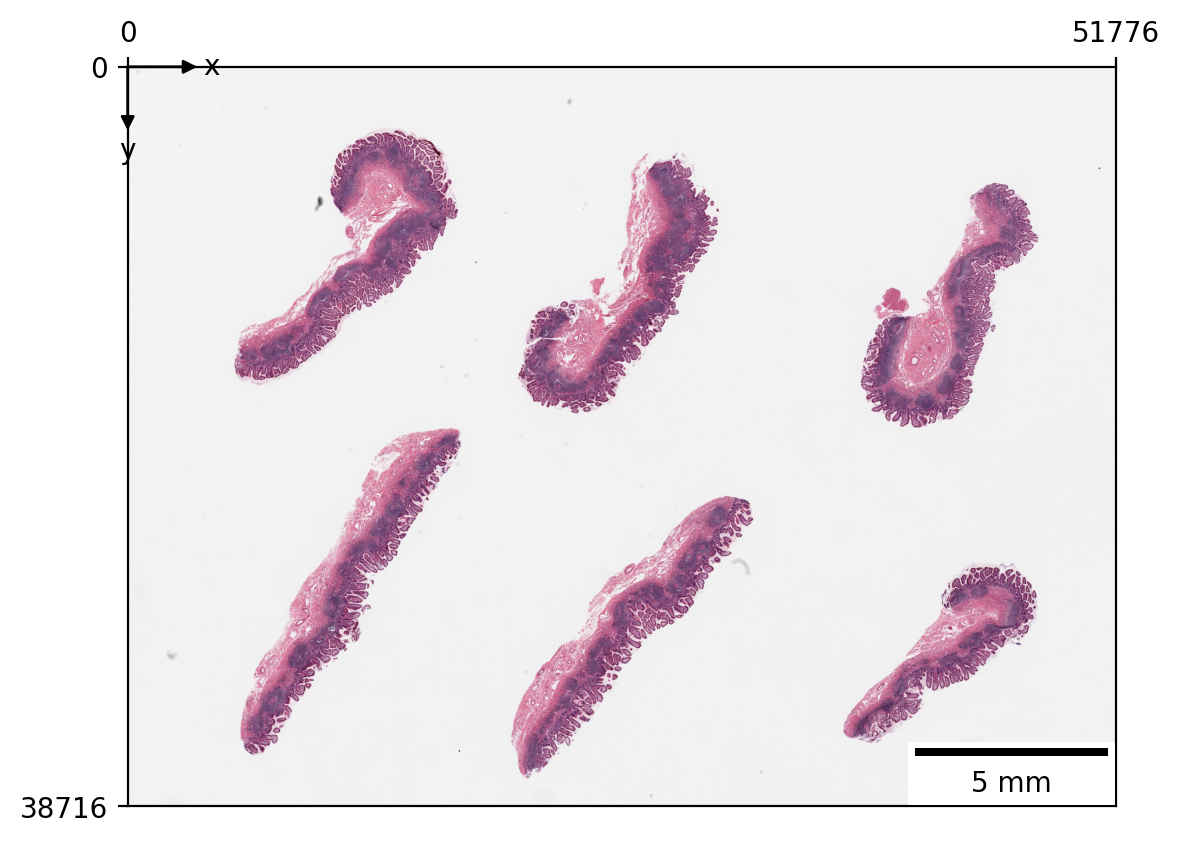

In [9]:
zs.pl.tissue(wsi)

## Preprocessing WSI

Before we can analyze the WSI, we need to preprocess it. The two main steps are:

1. **Tissue segmentation**: Identifying which parts of the slide contain actual tissue (vs. background/glass)
2. **Tissue tiling**: Dividing the tissue into smaller, manageable patches for analysis

These steps are analogous to quality control and preprocessing in single-cell analysis.

### Step 1: Tissue segmentation

The `find_tissues` function uses a simple threshold-based method to identify tissue regions. The `level=-1` parameter means we use the lowest resolution (thumbnail) for fast processing:

In [10]:
zs.pp.find_tissues(wsi, level=-1)

After tissue segmentation, the wsidata object now contains a 'tissues' element:

WSI: /Users/yzheng/.cache/huggingface/hub/datasets--rendeirolab--lazyslide-data/snapshots/9644d886889040fa10e757d912f249bbf936a979/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
└── Shapes
      └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)
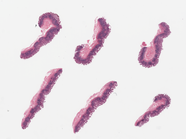

In [11]:
wsi

The `tissues` object is a GeoDataFrame containing the polygon geometries of detected tissue regions:

In [12]:
wsi["tissues"]

tissue_id                                           geometry
0          0  POLYGON ((45758.309 26024.138, 45742.304 26040...
1          1  POLYGON ((31305.789 22487.032, 31289.784 22503...
2          2  POLYGON ((16837.265 18949.926, 16821.26 18965....
3          3  POLYGON ((45342.178 6113.912, 45326.173 6129.9...
4          4  POLYGON ((28696.973 4561.426, 28680.968 4577.4...
5          5  POLYGON ((14164.429 3249.016, 14164.429 3265.0...

In [13]:
print(f"The type of wsi['tissues'] is: {type(wsi['tissues'])}")

The type of wsi['tissues'] is: <class 'geopandas.geodataframe.GeoDataFrame'>


Now when we visualize the tissue, the detected tissue boundaries are highlighted:

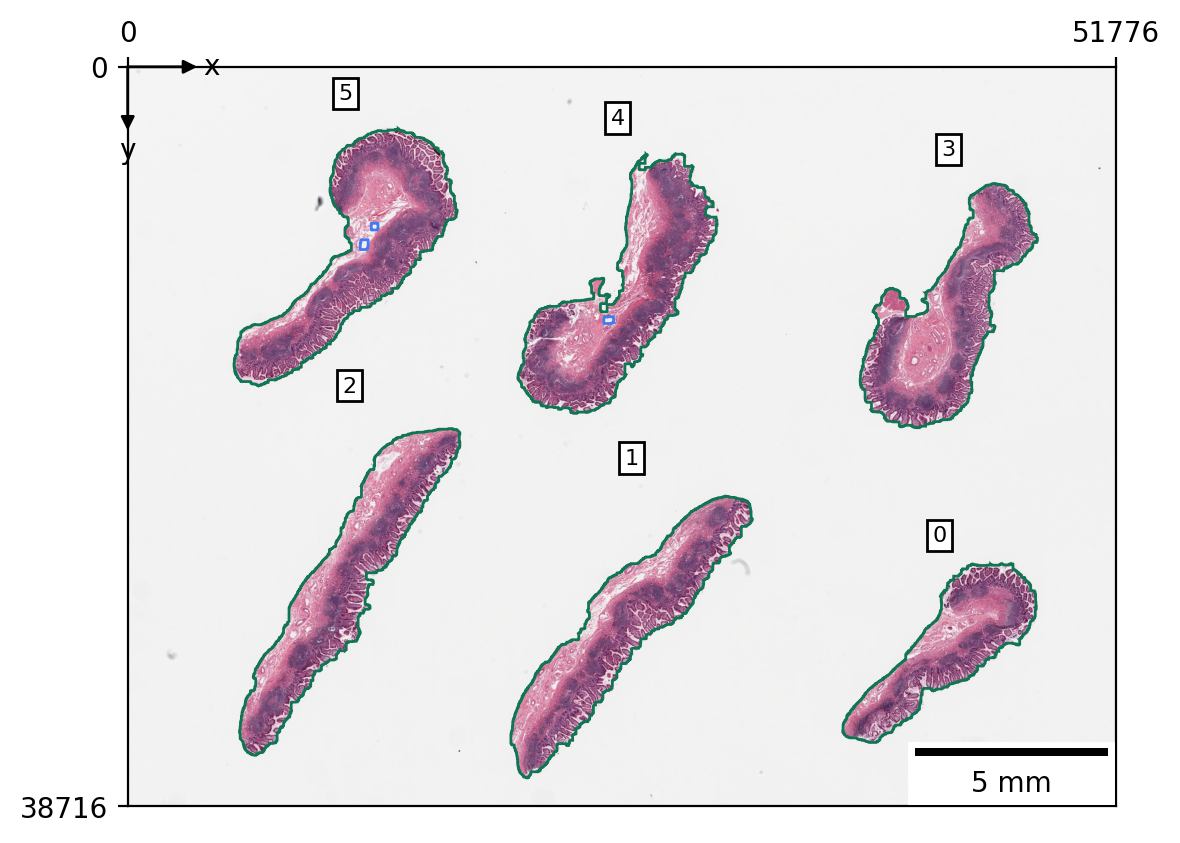

In [14]:
zs.pl.tissue(wsi)

It's possible to visualize each tissue piece individually using `tissue_id="all"`. This is helpful when multiple tissue pieces are present on the same slide:

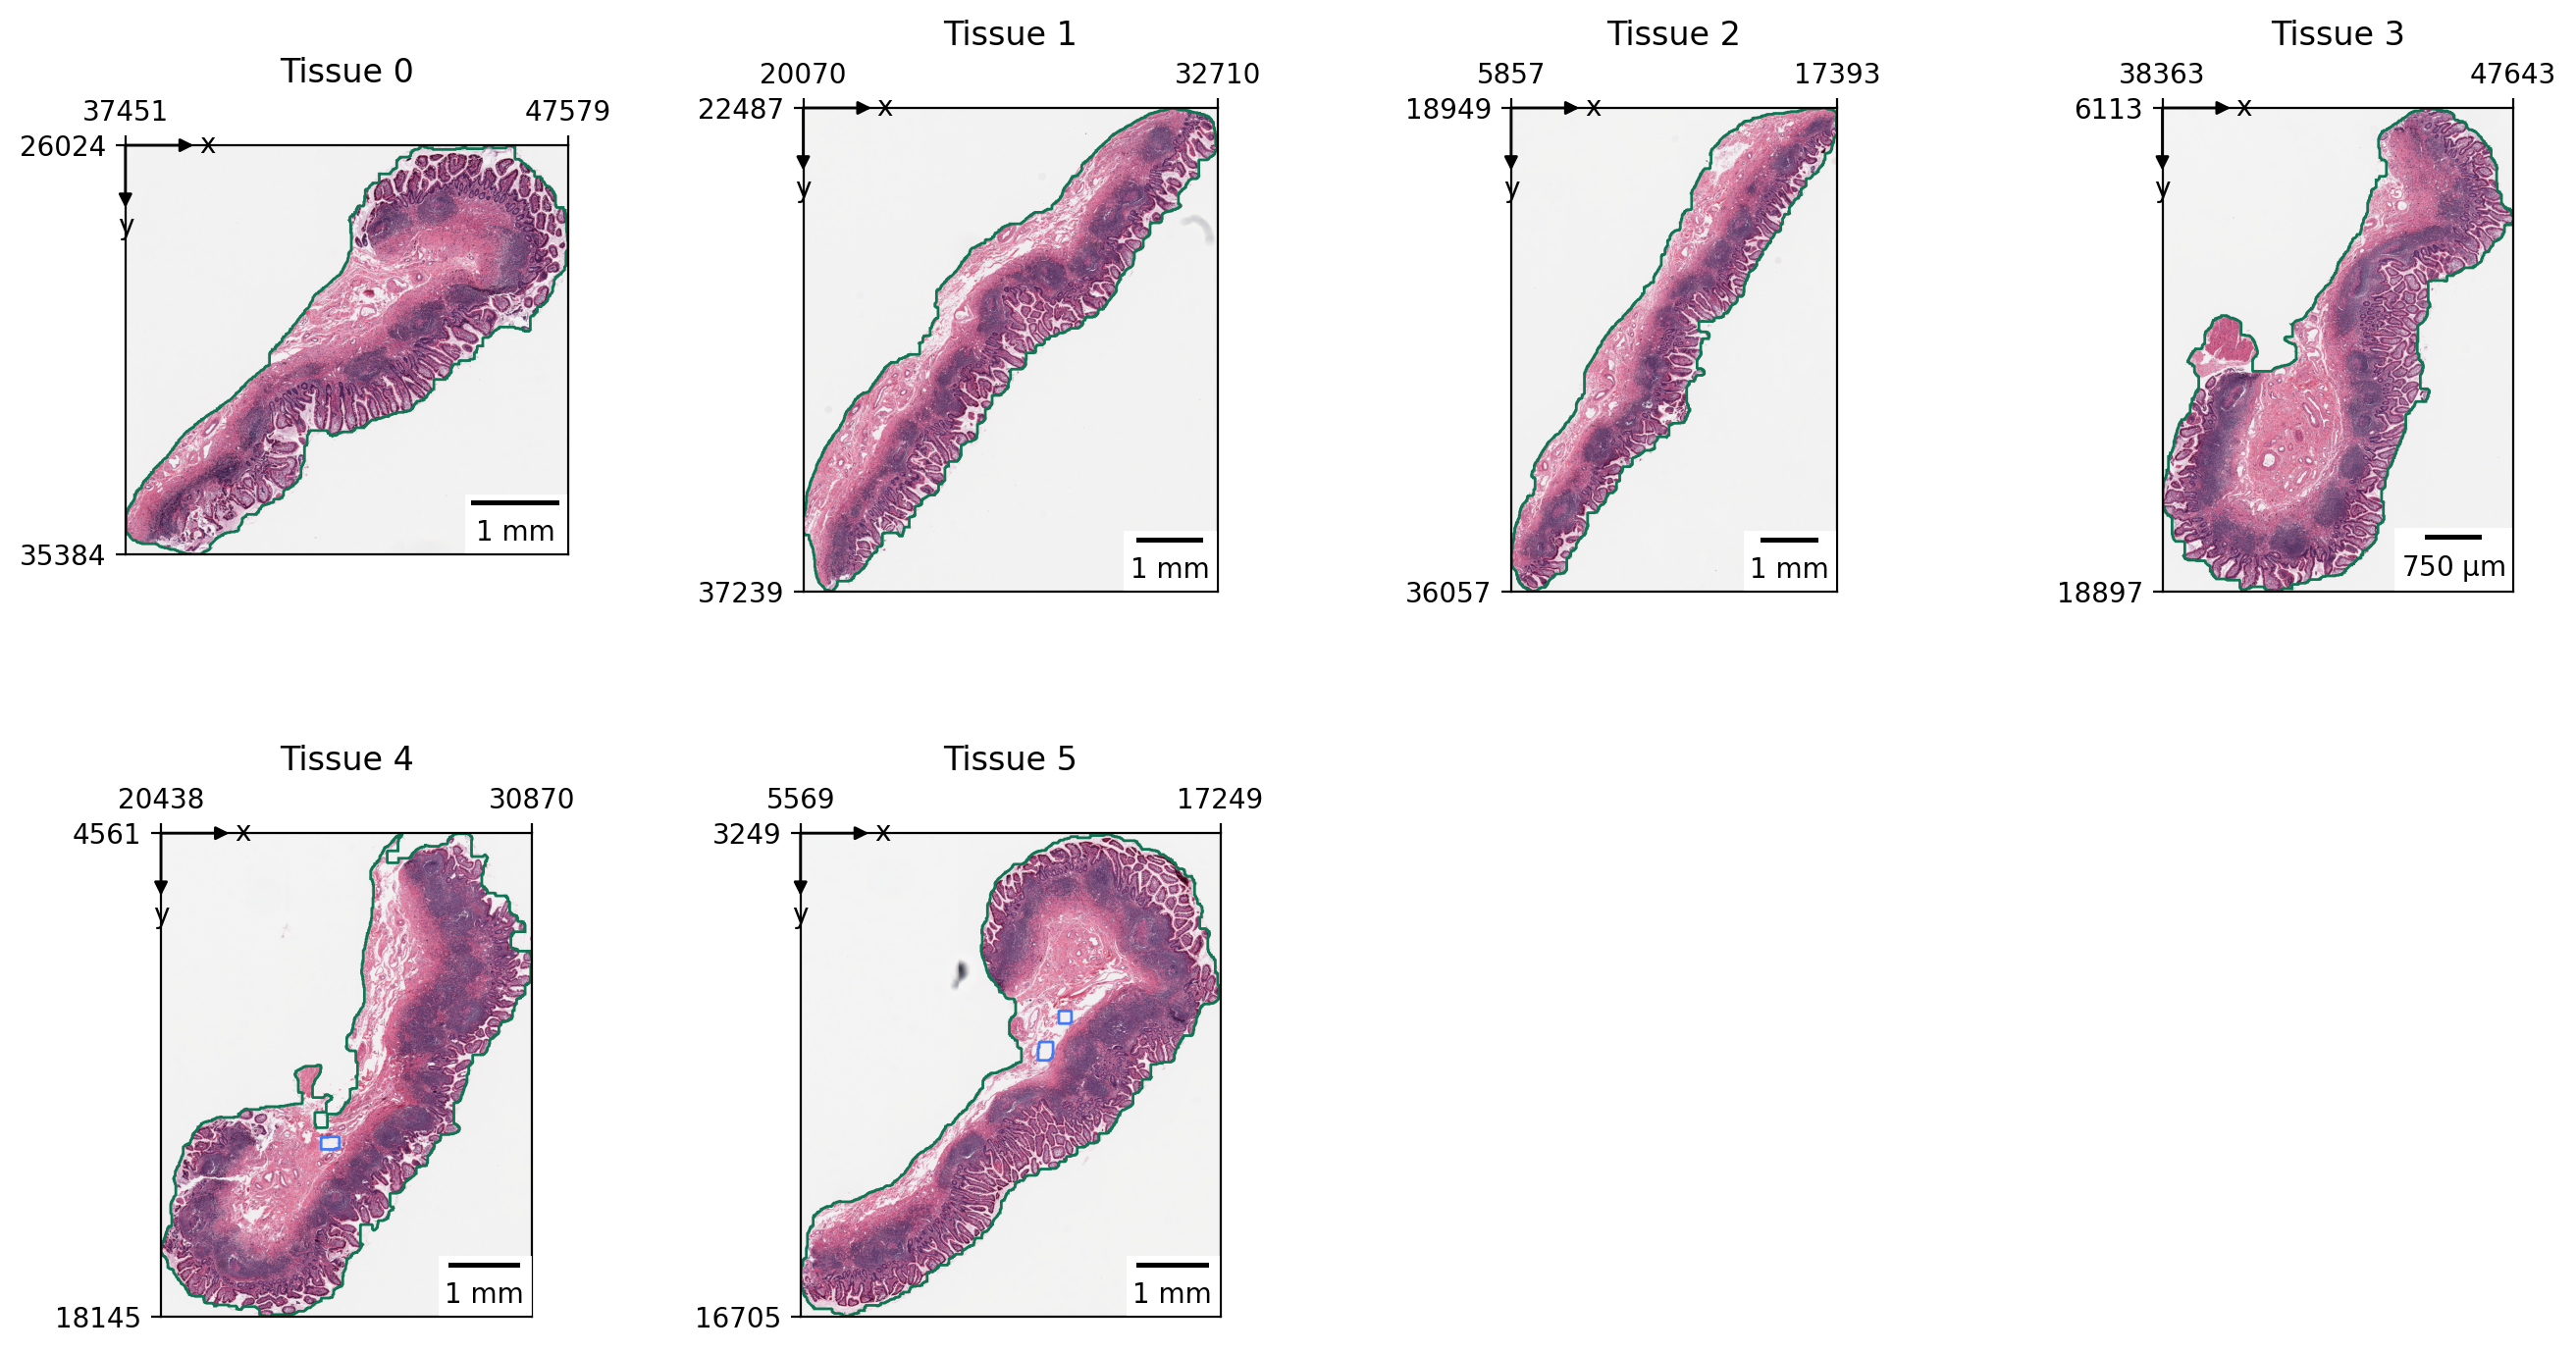

In [15]:
zs.pl.tissue(wsi, tissue_id="all")

### Alternative: Deep learning-based tissue segmentation

For more accurate segmentation, LazySlide also provides deep learning models. The `mpp` parameter specifies the resolution in microns per pixel:

In [16]:
zs.seg.tissue(wsi, key_added="dl-tissue", mpp=10)  # Runs on GPU when available

Visualize the deep learning-based segmentation results:

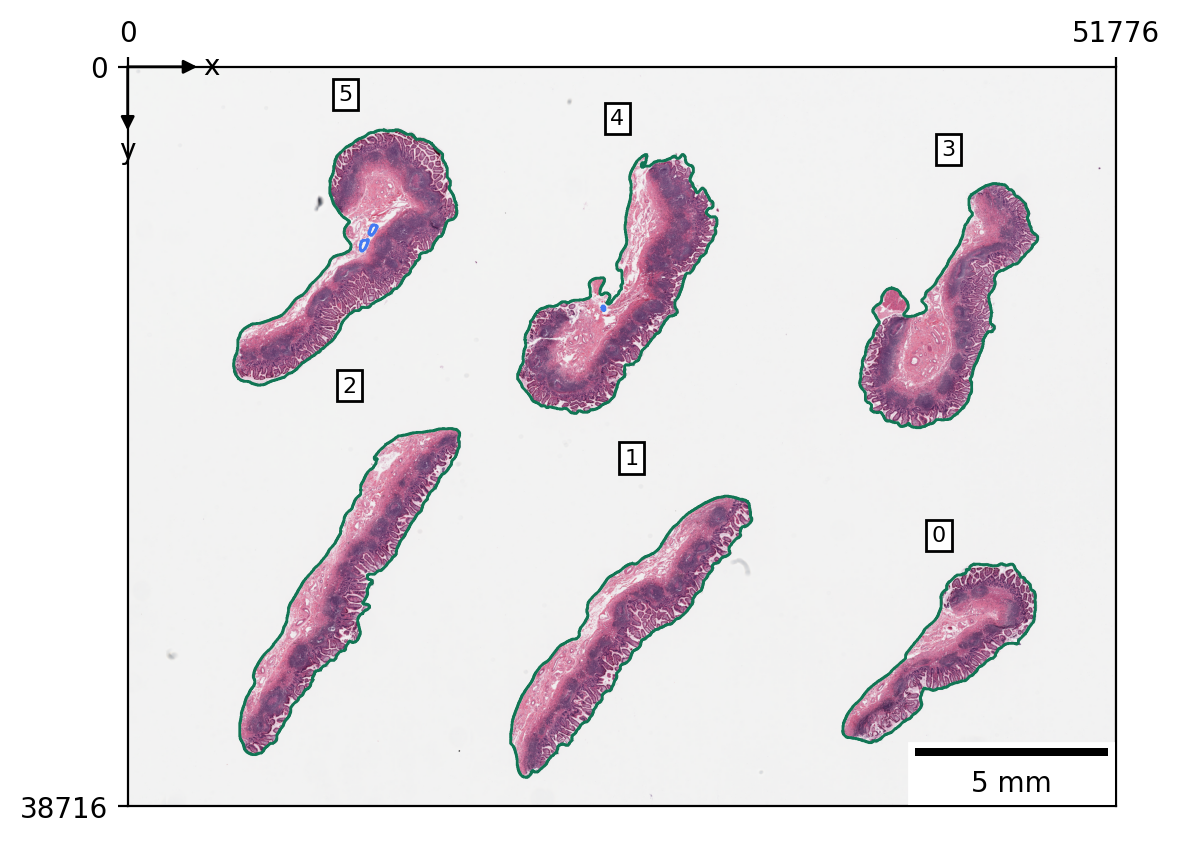

In [17]:
zs.pl.tissue(wsi, tissue_key="dl-tissue")

### Step 2: Tissue tiling

Now we'll divide the tissue into 512×512 pixel tiles. This is similar to creating "spots" in spatial transcriptomics data - each tile becomes a unit of analysis:

In [18]:
zs.pp.tile_tissues(wsi, 512)

The tiles are stored as a GeoDataFrame with spatial information about each tile:

In [19]:
wsi["tiles"]

tile_id  tissue_id                                           geometry
0           0          0  POLYGON ((37963 34216, 37963 34728, 37451 3472...
1           1          0  POLYGON ((38475 33704, 38475 34216, 37963 3421...
2           2          0  POLYGON ((38475 34216, 38475 34728, 37963 3472...
3           3          0  POLYGON ((38475 34728, 38475 35240, 37963 3524...
4           4          0  POLYGON ((38987 32680, 38987 33192, 38475 3319...
...       ...        ...                                                ...
1151     1151          5  POLYGON ((16833 6321, 16833 6833, 16321 6833, ...
1152     1152          5  POLYGON ((16833 6833, 16833 7345, 16321 7345, ...
1153     1153          5  POLYGON ((16833 7345, 16833 7857, 16321 7857, ...
1154     1154          5  POLYGON ((16833 7857, 16833 8369, 16321 8369, ...
1155     1155          5  POLYGON ((17345 7345, 17345 7857, 16833 7857, ...

[1156 rows x 3 columns]

Visualize the tiling grid overlaid on a specific tissue piece (tissue_id=1):

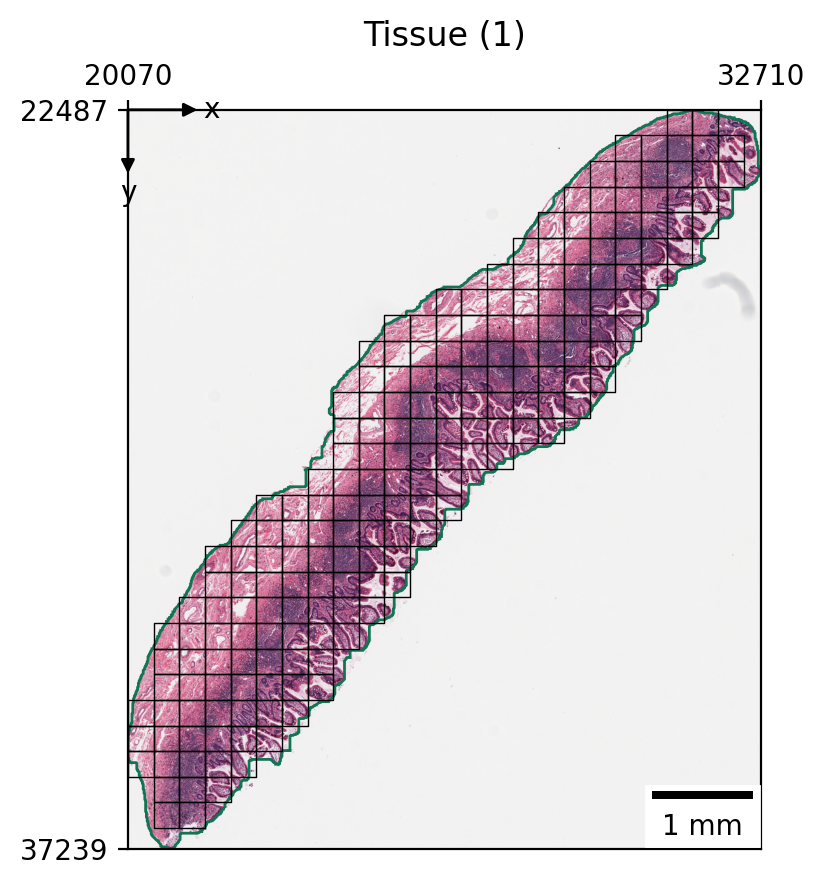

In [20]:
zs.pl.tiles(wsi, tissue_id=1, linewidth=0.5)

`TileSpec` records metadata about the tiling operation, including tile size, overlap, and resolution:

In [21]:
wsi.tile_spec("tiles")

Tile at 0.4942 mpp, 512×512 (h×w)
Stride: 512×512 (0×0 overlap)
Operation size: 512×512, level=0
Base size: 512×512, level=0
Target tissue: 'tissues'

**Try it yourself**

Can you try changing the tile size, overlap, or mpp (microns per pixel) and observe the changes in `TileSpec`? For example:
```python
zs.pp.tile_tissues(wsi, 256, overlap=0.1, mpp=0.5, key_added="tiles_custom")
wsi.tile_spec('tiles_custom')
```

Before we move to the next step, remember to save the analysis results.

In [22]:
wsi.write("results.zarr")

You can also save without specifying a path, this will write to a zarr file with the same name as the WSI side by side with the WSI file:

```python
wsi.write()
```

We can read the results back with:

In [23]:
wsi = open_wsi(slide, store="results.zarr")

## Morphological feature extraction

Now comes the exciting part! We'll extract deep learning features from each tile using foundation models trained on pathology images. 

**PLIP (Pathology Language-Image Pre-training)** is a vision-language model that understands both images and text in the pathology domain.

In [24]:
zs.tl.feature_extraction(wsi, model="plip")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


**Try it yourself**

Can you try to use other models? For example:

```python
zs.tl.feature_extraction(wsi, model="resnet50")
```

Extract features using the PLIP model. This will create an AnnData object where each tile is an "observation":

Notice the new `plip_tiles` table - this is an AnnData object containing the extracted features:

WSI: /Users/yzheng/.cache/huggingface/hub/datasets--rendeirolab--lazyslide-data/snapshots/9644d886889040fa10e757d912f249bbf936a979/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /Users/yzheng/Projects/scverse-workshop-lazyslide/results.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
├── Shapes
│     ├── 'dl-tissue': GeoDataFrame shape: (6, 2) (2D shapes)
│     ├── 'tiles': GeoDataFrame shape: (1156, 3) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
└── Tables
      └── 'plip_tiles': AnnData (1156, 512)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), dl-tissue (Shapes), tiles (Shapes), tissues (Shapes)
with the following elements not in the Zarr store:
    ▸ plip_tiles (Tables)
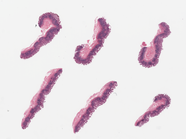

In [25]:
wsi

We can visualize individual feature dimensions. Each feature captures different morphological patterns:

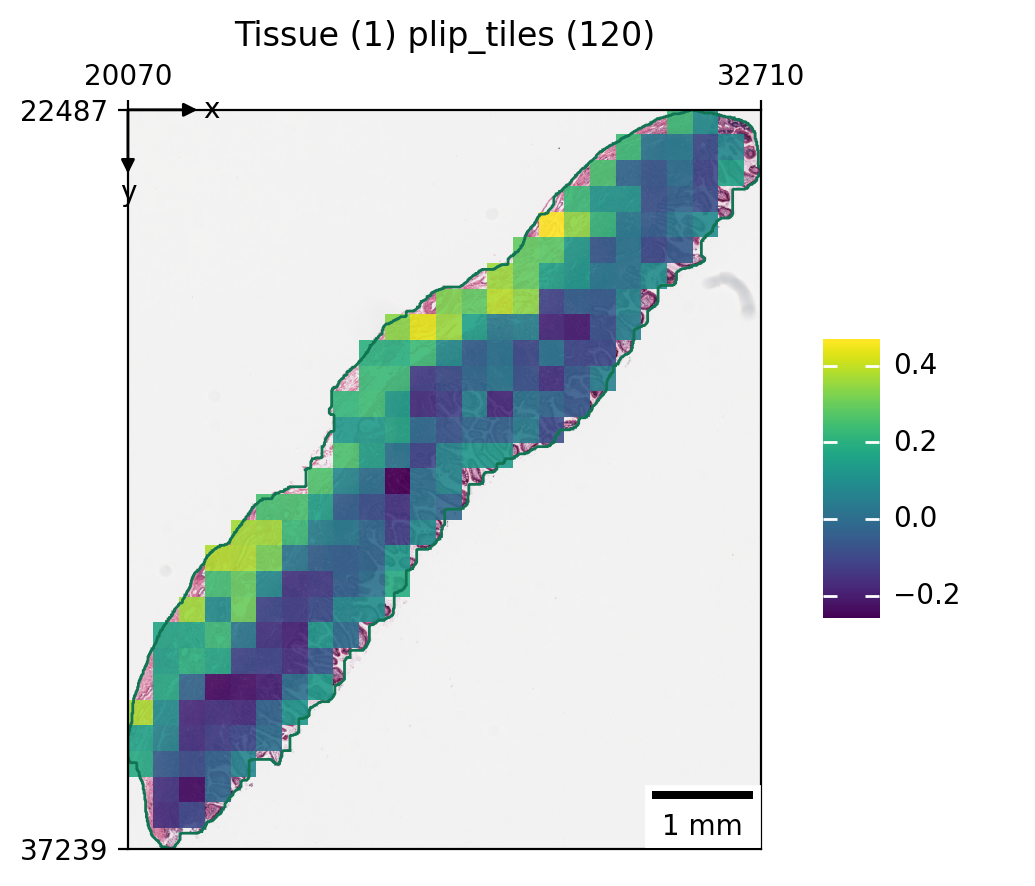

In [26]:
zs.pl.tiles(wsi, feature_key="plip", color=["120"], tissue_id=1, linewidth=0.5)

### Unsupervised clustering of tiles

Since we have an AnnData object, we can use familiar scanpy workflows! Let's perform dimensionality reduction and clustering:

In [27]:
import scanpy as sc

adata = wsi["plip_tiles"]
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.5)

Visualize the clusters in UMAP space - tiles with similar morphology cluster together:

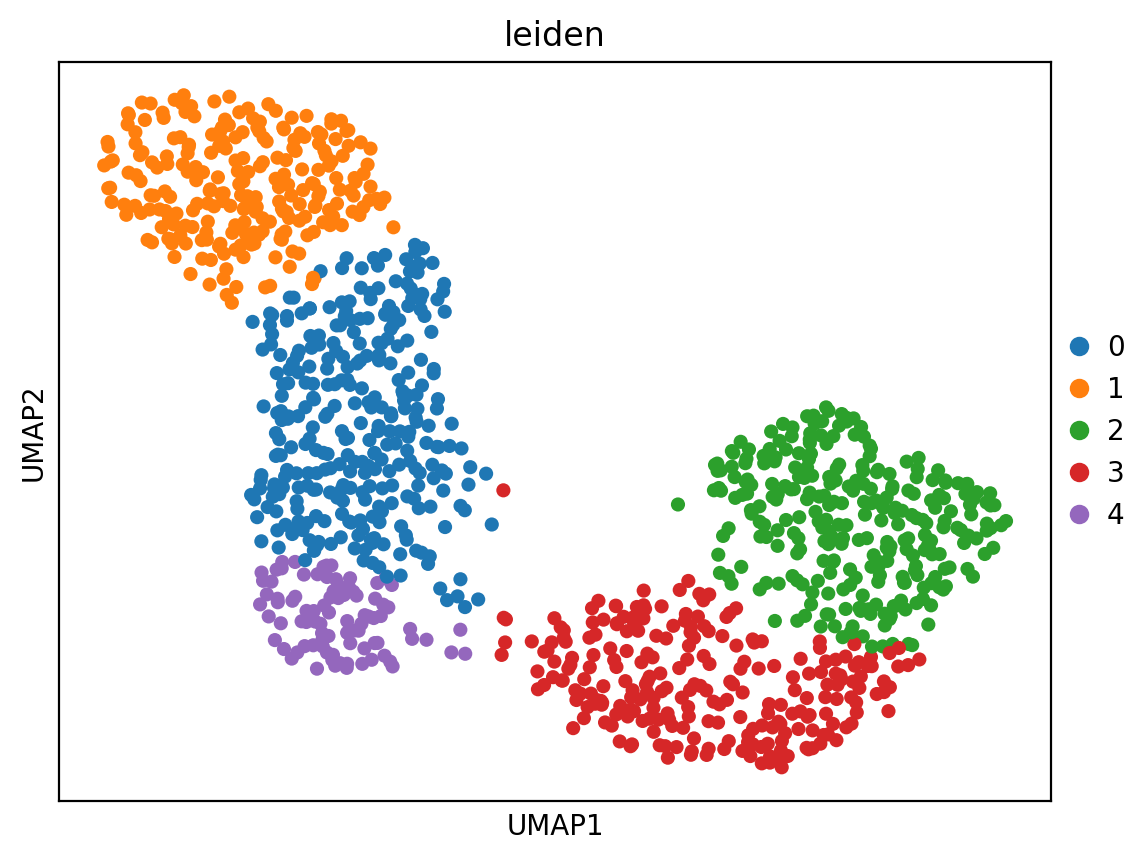

In [28]:
sc.pl.umap(adata, color="leiden")

### Challenge

Can we use human annotations to understand how does feature embedding changes between hisotological structures?

### Spatial domains

LazySlide provides a convenient wrapper that performs clustering while preserving spatial information:

In [29]:
zs.tl.spatial_domain(wsi, feature_key="plip", resolution=0.5)

Visualize the spatial domains directly on the tissue. Different colors represent morphologically distinct regions:

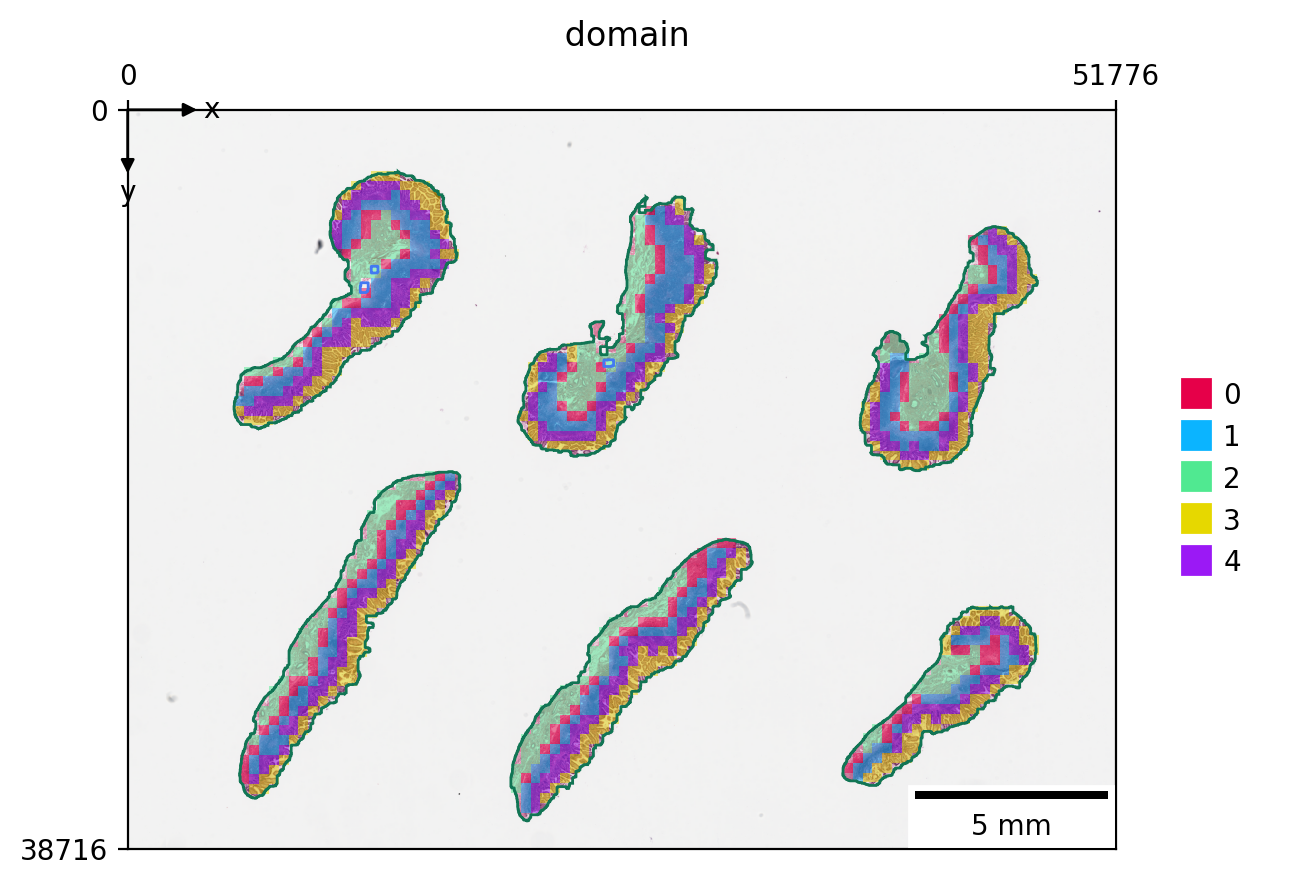

In [30]:
zs.pl.tiles(wsi, color="domain", alpha=0.5)

## Text-image similarity

One of the most powerful features of vision-language models like PLIP is the ability to query images using natural language. We can search for specific tissue types or structures using text descriptions!

In [31]:
terms = ["mucosa", "submucosa", "musclaris", "lymphocyte"]

embeddings = zs.tl.text_embedding(terms, model="plip")
zs.tl.text_image_similarity(wsi, embeddings, model="plip", softmax=True)

Define text terms for different tissue structures, compute their embeddings, and calculate similarity scores with each tile:

Visualize the text-image similarity scores. Brighter colors indicate higher similarity to each text term. The `smooth=True` option creates a smoother heatmap:

You can use the following image to learn a bit of small intestine histology:

<p align="center">
    <picture align="center">
    <img src="https://raw.githubusercontent.com/rendeirolab/lazyslide-workshop-scverse-conference-2025/main/assets/small_intestine.png" width="450px">
    </picture>
</p>

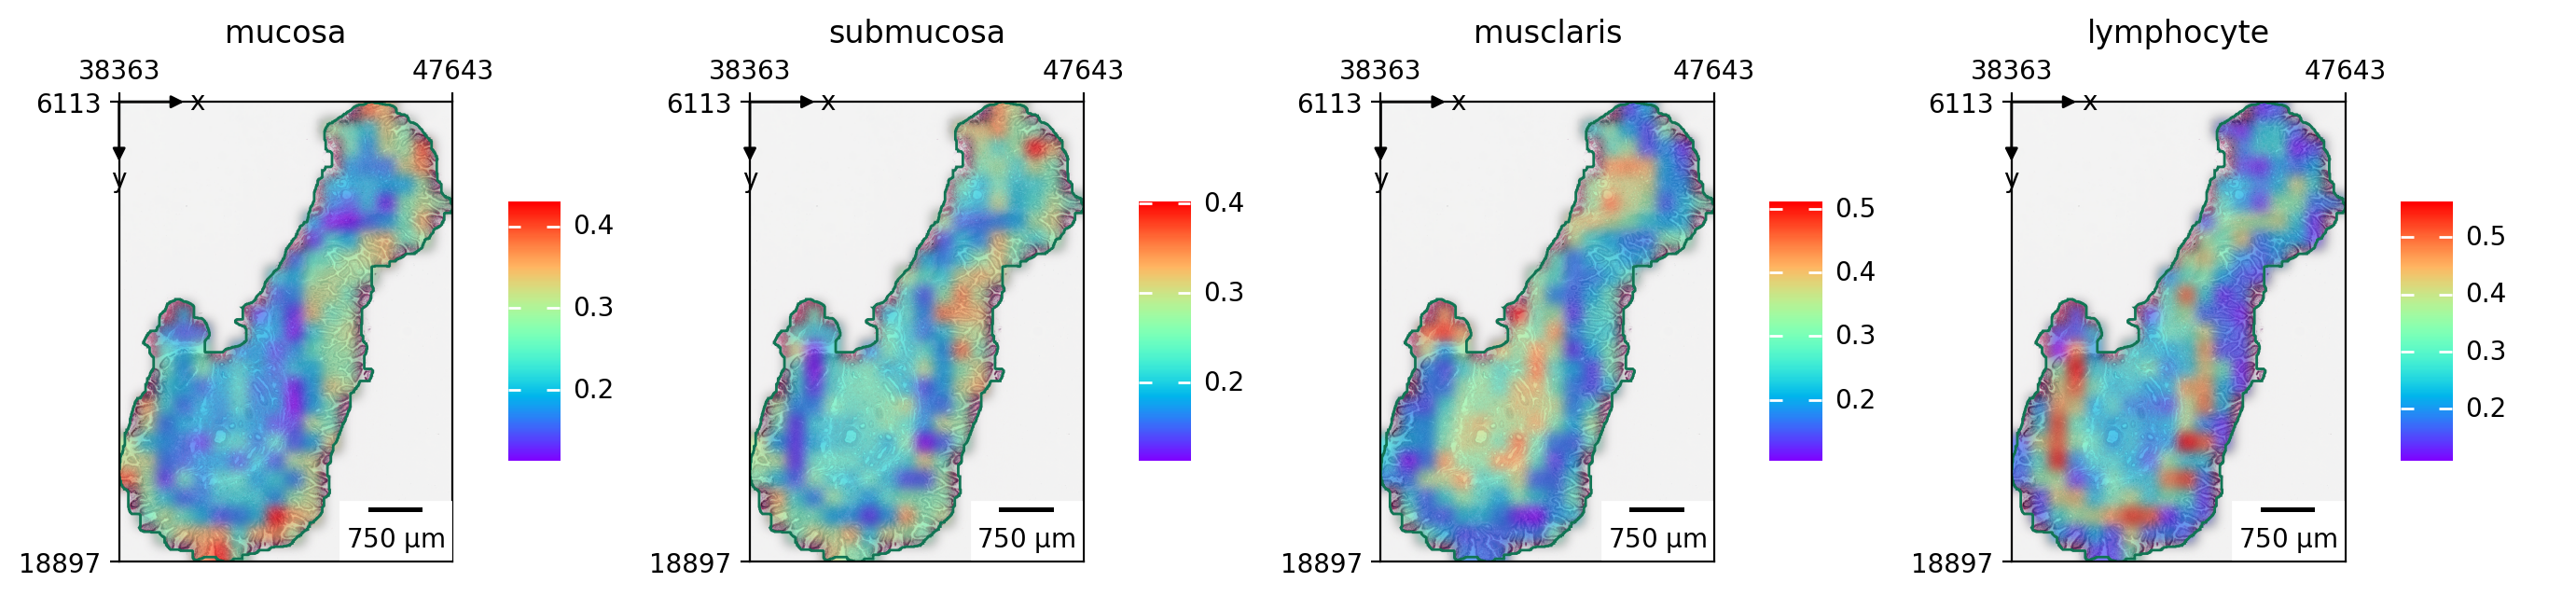

In [32]:
zs.pl.tiles(
    wsi,
    feature_key="plip_tiles_text_similarity",
    color=terms,
    cmap="rainbow",
    tissue_id=3,
    alpha=0.7,
    smooth=True,
    title=terms,
)

**Try it yourself**

Can you try to use other text terms or even sentences? Tips: 'Peyer’s patch', 'inflammation', 'immune'.

## Zero-shot classification

Zero-shot classification allows you to classify entire slides without training a model! This uses more advanced foundation models.

**Note**: You need to apply for access on Hugging Face for:
1. Virchow: https://huggingface.co/paige-ai/Virchow (tile-level feature extractor)
2. Prism: https://huggingface.co/paige-ai/Prism (slide-level aggregator)

First, extract features using the Virchow model (a powerful histopathology foundation model):

In [33]:
zs.tl.feature_extraction(wsi, "virchow")

Aggregate tile-level features into a single slide-level representation using the Prism encoder:

In [34]:
zs.tl.feature_aggregation(wsi, feature_key="virchow", encoder="prism", device="cpu")

Define candidate tissue types and compute zero-shot classification scores. The model will rank these classes by their likelihood:

In [35]:
classes = [
    "small intestine tissue",
    "large intestine tissue",
    "stomach tissue",
    "lymphoid tissue",
]
zs.tl.zero_shot_score(wsi, classes, feature_key="virchow_tiles", device="cpu")

small intestine tissue  large intestine tissue  stomach tissue  \
0                0.678176                0.314591         0.00044   

   lymphoid tissue  
0         0.006793

In [36]:
classes = [
    "EPCAM",  # Epithelial
    "MUC2",  # Goblet
    "CD45",  # Immune
    "ALB",  # Hepatocyte, liver-specific
]
zs.tl.zero_shot_score(wsi, classes, feature_key="virchow_tiles", device="cpu")

EPCAM      MUC2      CD45       ALB
0  0.380703  0.283119  0.311867  0.024311

**Try it yourself**

Can you think of some classes to confuse the model?

## Cell segmentation

Finally, let's perform cell-level analysis! Cell segmentation identifies individual cells within the tissue, enabling single-cell spatial analysis.

For this demonstration, we'll load a different sample dataset optimized for cell segmentation:

In [37]:
wsi = zs.datasets.sample()

Load a sample dataset with high-resolution tissue suitable for cell segmentation:

WSI: /Users/yzheng/.cache/huggingface/hub/datasets--RendeiroLab--LazySlide-data/snapshots/9644d886889040fa10e757d912f249bbf936a979/sample.svs
Reader: openslide
Dimensions: 2967×2220 (h×w), 1 Pyramid
Pixel physical size: 0.499 MPP
SpatialData object, with associated Zarr store: /Users/yzheng/.cache/huggingface/hub/datasets--RendeiroLab--LazySlide-data/snapshots/9644d886889040fa10e757d912f249bbf936a979/sample.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1496, 1119)
├── Shapes
│     ├── 'annotations': GeoDataFrame shape: (3, 4) (2D shapes)
│     ├── 'dl-tissue': GeoDataFrame shape: (2, 2) (2D shapes)
│     ├── 'tiles': GeoDataFrame shape: (31, 3) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (1, 2) (2D shapes)
└── Tables
      └── 'resnet50_tiles': AnnData (31, 2048)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), annotations (Shapes), dl-tissue (Shapes), tiles (Shapes), tissues (Shapes)
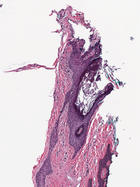

In [38]:
wsi

Create tiles for cell segmentation. 

- 20% overlap to improve segmentation quality
- `background_filter=False` to cover all edge tiles, not just tissue-rich ones

In [39]:
zs.pp.tile_tissues(
    wsi, 512, overlap=0.2, key_added="cell_seg_tiles", background_filter=False
)

Perform cell segmentation using Cellpose, a deep learning model for cell and nucleus detection:

In [40]:
zs.seg.cells(wsi, model="cellpose", tile_key="cell_seg_tiles")

Visualize the segmented cells. Each cell is outlined, allowing for single-cell spatial analysis:

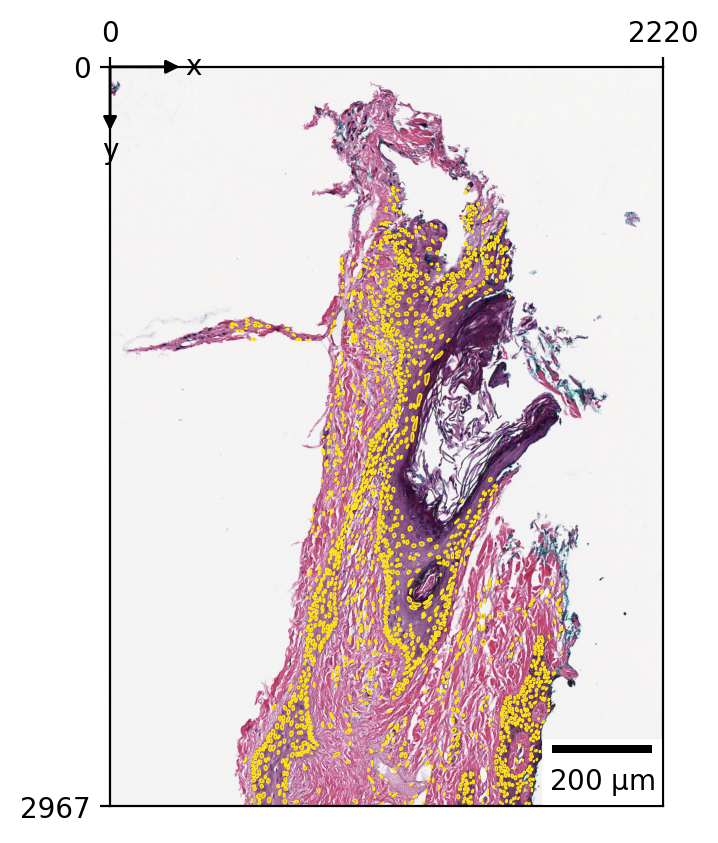

In [41]:
zs.pl.annotations(wsi, "cells")

You can also perform segmentation and classification at the same time!

```python
zs.pp.tile_tissues(wsi, 840, overlap=0.2, key_added="cell_seg_tiles", background_filter=False)
zs.seg.cell_types(wsi, model="nulite", tile_key="cell_seg_tiles") # or model="histoplus"

zs.pl.annotations(wsi, "cell_types", color="class")
```

---

## Summary

Congratulations! You've completed the LazySlide workshop. You've learned how to:

1. ✅ **Load and explore WSI data** - Understanding the structure and metadata of whole slide images
2. ✅ **Preprocess WSI** - Tissue segmentation and tiling for analysis
3. ✅ **Extract morphological features** - Using foundation models like PLIP to capture tissue characteristics
4. ✅ **Perform spatial analysis** - Unsupervised clustering and spatial domain identification
5. ✅ **Query with text** - Using vision-language models for text-to-image similarity
6. ✅ **Zero-shot classification** - Classifying slides without training data
7. ✅ **Segment cells** - Identifying individual cells for single-cell spatial analysis

### Next steps

- Explore the [LazySlide documentation](https://lazyslide.readthedocs.io/) for more advanced tutorials
- Try applying these methods to your own WSI data
- Combine WSI features with spatial transcriptomics or other molecular data
- Check out the [wsidata tutorials](https://wsidata.readthedocs.io/) for advanced data handling

### Challenge

- Can we use feature embeddings to build a survival model on diseases?

### Questions?

Feel free to open issues on our GitHub repositories:
- [LazySlide GitHub](https://github.com/rendeirolab/LazySlide)
- [wsidata GitHub](https://github.com/rendeirolab/wsidata)

If you found this helpful, please ⭐ star our repositories!